# 1 - Analysis of the dataset

In [2]:
# Google Colab

google_colab = False
if google_colab:
    !pip install emoji
    import nltk
    nltk.download('punkt')
    nltk.download('stopwords')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji # for demojize
import re # for regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer # for Pipeline
from sklearn.naive_bayes import MultinomialNB

#### 1.1 - Loading the dataset

In [4]:
df = pd.read_csv("content\Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.shape

(14640, 15)

In [6]:
df[df["tweet_id"] == 570307948171423745]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11882,570307948171423745,negative,0.6846,Flight Booking Problems,0.6846,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I pay $200 to reactivat...,NaN,2015-02-24 11:43:05 -0800,NaN,Quito
12043,570307948171423745,negative,1.0000,Can't Tell,0.6758,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I pay $200 to reactivat...,NaN,2015-02-24 11:43:05 -0800,NaN,Quito


So, the dataset contains 14640 entries and has 15 columns. The ones that we are interested in are "airline_sentiment" and "text". It represents the sentiment felt by the author of the tweet about US Airlines, 3 possible cases : positive, neutral, negative. At first glance, I do not think that the other columns are relevant in our project as we do not want the model to overfit on for instance Twitter's username or airline.

#### 1.2 - Removing duplications

In [7]:
df[df.duplicated(subset=["tweet_id"], keep=False)].sort_values(by="tweet_id")

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12033,569600137296633856,positive,0.9236,NaN,0.0000,American,positive,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14556,569600137296633856,positive,1.0000,NaN,NaN,American,NaN,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12032,569601363799359488,negative,0.9553,Flight Attendant Complaints,0.9553,American,negative,stevereasnors,Flight Attendant Complaints,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12031,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,negative,salitron78,Customer Service Issue,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12042,570307949614256128,negative,1.0000,Can't Tell,1.0000,American,NaN,ELLLORRAC,NaN,0,@AmericanAir thanks for getting back to me. Bu...,NaN,2015-02-24 11:43:05 -0800,NaN,Central Time (US & Canada)
11880,570308064185880577,neutral,0.6667,NaN,NaN,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12041,570308064185880577,neutral,0.6755,NaN,0.0000,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12040,570308309682675712,negative,1.0000,Customer Service Issue,1.0000,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito


Thanks to the "tweet_id", we can see that we have duplications. Exactly, 155 duplications.

In [8]:
df.drop_duplicates(subset=["tweet_id"], keep="first", inplace=True)


In [9]:
df[df.duplicated(subset=["tweet_id"], keep=False)]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In [10]:
assert(df.shape == (14640-155, 15)), "The shape of the df without duplication is incorrect."
df.shape

(14485, 15)

#### 1.3 - Frequencies of sentiments in the dataset

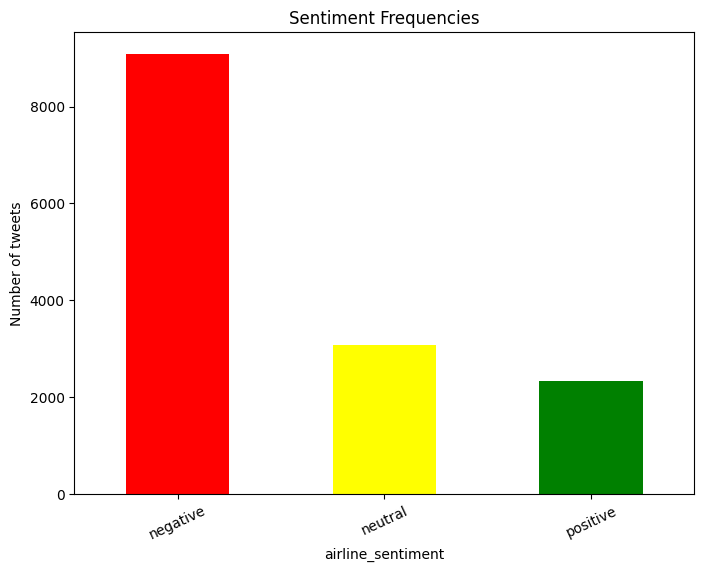

In [11]:
sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Frequencies')
plt.ylabel('Number of tweets')
plt.xticks(rotation=25)
plt.show()

In [12]:
for sentiment, count in sentiment_counts.items():
    print(f"There are {count} tweets with {sentiment} sentiment.")

There are 9082 tweets with negative sentiment.
There are 3069 tweets with neutral sentiment.
There are 2334 tweets with positive sentiment.


As we see, there are a lot of negative tweets about airlines, I think it is pretty normal as people are mostlikely going to say something when it is bad then when it is good. When it is good, it is "normal" for the passenger and does not require to say anything about it. But when it is really really good, they are going to say it. It is the negativity bias (tendency for humans to pay more attention to negative events or experiences compared to positive ones)

For the neutral ones, I do not really know if the dataset is mislabeled. I will try to read some of them later to check.

#### 1.4 - Frequencies of negative sentiment by Airlines

For fun, let's see which company has the most negative tweets.

In [13]:
sentiment_by_company = df.groupby(['airline', 'airline_sentiment']).size().unstack()

sentiment_by_company

airline_sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


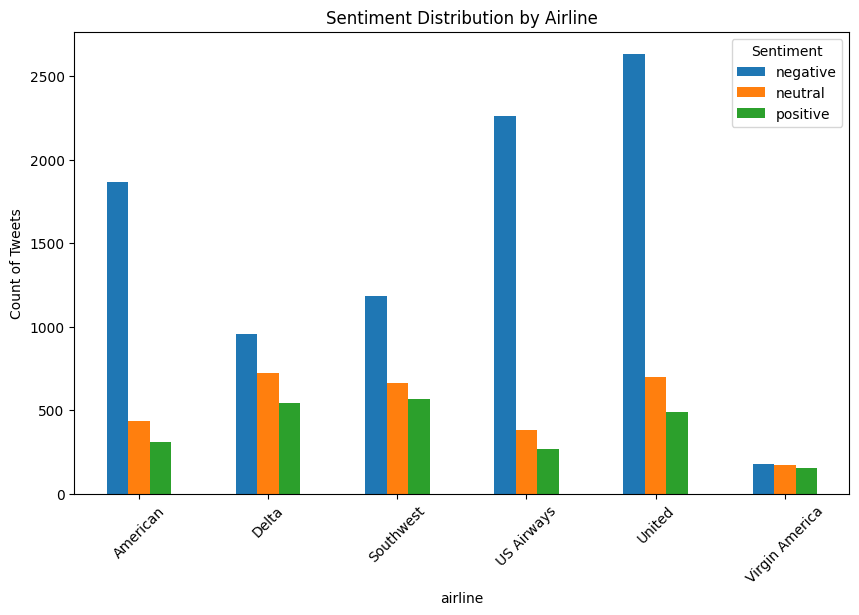

In [14]:
sentiment_by_company.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Sentiment Distribution by Airline')
plt.ylabel('Count of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

In [15]:
negative_tweets_by_company = sentiment_by_company["negative"]
total_tweets_by_company = sentiment_by_company.sum(axis=1)
negative_tweet_rate = (negative_tweets_by_company / total_tweets_by_company).sort_values(ascending=False)

print("Rate of Negative Tweets by Companies:")
print(negative_tweet_rate)

Rate of Negative Tweets by Companies:
airline
US Airways        0.776862
American          0.715822
United            0.688906
Southwest         0.490083
Delta             0.429793
Virgin America    0.359127
dtype: float64


We can see that passengers seem to not like US Airways, American Airlines, United Airlines. Delta Airlines seems to be less hated. About Virgin America, we can't really say anything as there are only around 500 tweets about this company.

#### 1.5 - Length of tweets

In [16]:
negative_lengths = df[df['airline_sentiment'] == 'negative']['text'].str.len()
negative_lengths.mean()

113.93536665932614

In [17]:
negative_word_counts = df[df['airline_sentiment'] == 'negative']['text'].str.split().apply(len)
negative_word_counts.mean()

19.689385597885927

In [18]:
positive_lengths = df[df['airline_sentiment'] == 'positive']['text'].str.len()
positive_lengths.mean()

86.29134532990574

In [19]:
positive_word_counts = df[df['airline_sentiment'] == 'positive']['text'].str.split().apply(len)
positive_word_counts.mean()

14.050985432733505

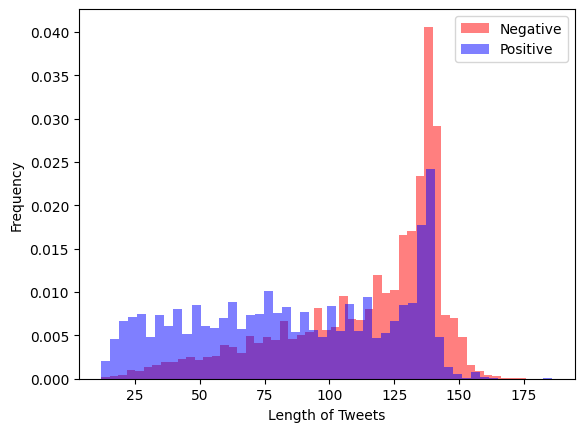

In [20]:
plt.hist(negative_lengths, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_lengths, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

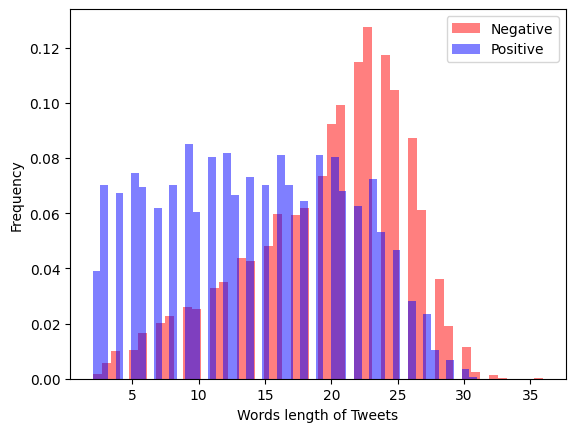

In [21]:
plt.hist(negative_word_counts, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_word_counts, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Words length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that in average, negative tweets have 20 words for 114 characters and positive tweets have 14 words for 86 characters. We may use it as a feature in our model.

# 2 - Pre-processing

#### 2.1 - Removing the useless columns

In [22]:
df = df[["text", "airline_sentiment"]]
df.head(20)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


In [23]:
df = df[df['airline_sentiment'] != 'neutral']
df.head(20)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive
12,@VirginAmerica This is such a great deal! Alre...,positive
13,@VirginAmerica @virginmedia I'm flying your #f...,positive


In [24]:
df.shape

(11416, 2)

#### 2.2 - Converting emojis

For index 18, the emoji ❤️ is important because otherwise we can't understand the analysis of just "I flying". So, now we are going to try to take care of emojis / smileys first.

In [25]:
print(emoji.demojize(df.iloc[15]["text"]))

@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.


In [26]:
df['preprocessed_text'] = df['text'].apply(emoji.demojize)
df.head(20)

,text,airline_sentiment,preprocessed_text
1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...
3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...
5,@VirginAmerica seriously would pay $30 a fligh...,negative,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"@VirginAmerica it was amazing, and arrived an ..."
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...
12,@VirginAmerica This is such a great deal! Alre...,positive,@VirginAmerica This is such a great deal! Alre...
13,@VirginAmerica @virginmedia I'm flying your #f...,positive,@VirginAmerica @virginmedia I'm flying your #f...


#### 2.3 - Tokenization and removing stopwords, symbols and company's name

In [27]:
def remove_symbols(text):
    text = text.replace("::", " ") # In case there are two emojis in a row

    # Regular expression
    pattern = r'[^a-zA-Z0-9\s]'

    # Replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

remove_symbols(df.iloc[15]["preprocessed_text"])

'VirginAmerica you know what would be amazingly awesome BOSFLL PLEASE I want to fly with only you'

In [28]:
companies = ['virginamerica', 'united', 'southwest', 'delta', 'usairways', 'americanair', 'usairway', 'southwestair']

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    tokens = [remove_symbols(text) for text in tokens if len(remove_symbols(text)) != 0]

    # Remove the first "@" symbol and the company name (first mention in the tweet)
    if "@" in tokens:
        index = tokens.index("@")
        del tokens[index]
        if index < len(tokens):
            del tokens[index]

    # Remove stopwords and company name (in case they say the name of the company after the first mention)
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in companies]

    # Lemmatize tokens using spaCy because NLTK is not good enough if you do not precise the POS (ex: flying -> flying)
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]

    return tokens

df['preprocessed_text'] = df['preprocessed_text'].apply(preprocess_text)
df.head(20)

,text,airline_sentiment,preprocessed_text
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]"
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta..."
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,..."
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,..."
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]"
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive,"[lt, 3, pretty, graphic, much, well, minimal, ..."
12,@VirginAmerica This is such a great deal! Alre...,positive,"[great, deal, already, think, 2nd, trip, austr..."
13,@VirginAmerica @virginmedia I'm flying your #f...,positive,"[virginmedia, fly, fabulous, seductive, sky, u..."


#### 2.4 - Word cloud

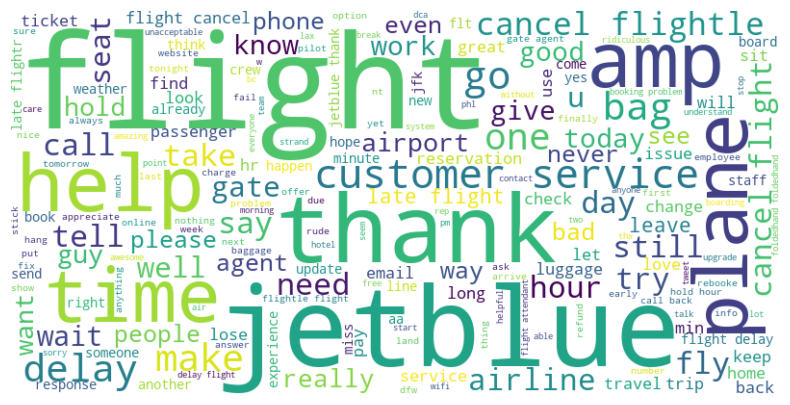

In [29]:
text = ' '.join(df['preprocessed_text'].explode().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It's to check if there are not the companies' name anymore.

#### 2.5 - Length of tweets

In [30]:
df['tweet_length'] = df['text'].str.len()

df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]",72
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]",80
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive,"[lt, 3, pretty, graphic, much, well, minimal, ...",83
12,@VirginAmerica This is such a great deal! Alre...,positive,"[great, deal, already, think, 2nd, trip, austr...",139
13,@VirginAmerica @virginmedia I'm flying your #f...,positive,"[virginmedia, fly, fabulous, seductive, sky, u...",140


#### 2.6 -  Transform sentiment to numerical value

Last thing to do is to transform the label into numerical value as : negative 0, positive 1.

In [31]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative': 0, 'positive': 1})
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
1,@VirginAmerica plus you've added commercials t...,1,"[plus, add, commercial, experience, tacky]",72
3,@VirginAmerica it's really aggressive to blast...,0,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,0,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,0,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",1,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",1,"[amazing, arrive, hour, early, good]",80
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,1,"[lt, 3, pretty, graphic, much, well, minimal, ...",83
12,@VirginAmerica This is such a great deal! Alre...,1,"[great, deal, already, think, 2nd, trip, austr...",139
13,@VirginAmerica @virginmedia I'm flying your #f...,1,"[virginmedia, fly, fabulous, seductive, sky, u...",140


In [32]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(x))   # useful later for TfidfVectorizer
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
1,@VirginAmerica plus you've added commercials t...,1,plus add commercial experience tacky,72
3,@VirginAmerica it's really aggressive to blast...,0,really aggressive blast obnoxious entertainmen...,126
4,@VirginAmerica and it's a really big bad thing...,0,really big bad thing,55
5,@VirginAmerica seriously would pay $30 a fligh...,0,seriously would pay 30 flight seat not play re...,135
6,"@VirginAmerica yes, nearly every time I fly VX...",1,yes nearly every time fly vx ear worm go away,79
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1,well didntbut,47
9,"@VirginAmerica it was amazing, and arrived an ...",1,amazing arrive hour early good,80
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,1,lt 3 pretty graphic much well minimal iconography,83
12,@VirginAmerica This is such a great deal! Alre...,1,great deal already think 2nd trip australia am...,139
13,@VirginAmerica @virginmedia I'm flying your #f...,1,virginmedia fly fabulous seductive sky u take ...,140


# 3. Modelisation

##### 3.1 - Baseline model (always predicting negative)

In [33]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation
y_train_pred = [0] * len(X_train)
y_test_pred = [0] * len(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Baseline model on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Baseline model on test set: {accuracy} \n")

print("Classification Report of Baseline Model :")
print(classification_report(y_test, y_test_pred, zero_division=1))

Accuracy of Baseline model on train set: 0.7948970652650021
Accuracy of Baseline model on test set: 0.7981611208406305 

Classification Report of Baseline Model :
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1823
           1       1.00      0.00      0.00       461

    accuracy                           0.80      2284
   macro avg       0.90      0.50      0.44      2284
weighted avg       0.84      0.80      0.71      2284



#### 3.2 - Logistic Regression with TF-IDF

In [34]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)


# Code before Pipeline
# # TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

# # Logistic Regression training
# logreg_model = LogisticRegression(max_iter=1000)
# logreg_model.fit(X_train_tfidf, y_train)



# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Logistic Regression TF-IDF on train set: 0.9236749890494963
Accuracy of Logistic Regression TF-IDF on test set: 0.9063047285464098 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1823
           1       0.89      0.61      0.72       461

    accuracy                           0.91      2284
   macro avg       0.90      0.80      0.83      2284
weighted avg       0.91      0.91      0.90      2284



#### 3.3 - Logistic Regression with TF-IDF & tweet length

In [35]:
X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF & tweet length on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF & tweet length on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Logistic Regression TF-IDF & tweet length on train set: 0.923784494086728
Accuracy of Logistic Regression TF-IDF & tweet length on test set: 0.9089316987740805 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1823
           1       0.89      0.62      0.73       461

    accuracy                           0.91      2284
   macro avg       0.90      0.80      0.84      2284
weighted avg       0.91      0.91      0.90      2284



#### 3.4 - Naive Bayes TF-IDF

In [36]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Naive Bayes with TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.8911519929916776
Accuracy of Naive Bayes TF-IDF on test set: 0.8690893169877408 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1823
           1       0.96      0.37      0.53       461

    accuracy                           0.87      2284
   macro avg       0.91      0.68      0.73      2284
weighted avg       0.88      0.87      0.84      2284



#### Naive Bayes TD-IDF & tweet length

In [37]:
X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Naive Bayes with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', MultinomialNB())
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF & tweet length on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF & tweet length on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF & tweet length on train set: 0.8518396846254928
Accuracy of Naive Bayes TF-IDF & tweet length on test set: 0.8436952714535902 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1823
           1       0.98      0.23      0.37       461

    accuracy                           0.84      2284
   macro avg       0.91      0.61      0.64      2284
weighted avg       0.87      0.84      0.80      2284



#### Logistic Regression TF 1-gram and 2-gram

In [38]:
X = df['text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 1-gram and 2-gram
pipeline = Pipeline([
    ('tfidf', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.9993429697766097
Accuracy of Naive Bayes TF-IDF on test set: 0.9238178633975481 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1823
           1       0.87      0.73      0.79       461

    accuracy                           0.92      2284
   macro avg       0.90      0.85      0.87      2284
weighted avg       0.92      0.92      0.92      2284



#### Logistic Regression TF 2-gram + TD-IDF 4-gram + TD-IDF

In [39]:
X = df[['text', 'preprocessed_text']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text')
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.9998904949627683
Accuracy of Naive Bayes TF-IDF on test set: 0.9260070052539404 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1823
           1       0.88      0.73      0.80       461

    accuracy                           0.93      2284
   macro avg       0.91      0.85      0.88      2284
weighted avg       0.92      0.93      0.92      2284



#### Pre-trained model : Distilbert finetuned on SST2

In [40]:
if google_colab: 
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch

    X = df[['text', 'preprocessed_text']]
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load pre-trained model and tokenizer
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Tokenize input sentences
    inputs = tokenizer(X_test['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predictions
    y_test_pred = torch.argmax(outputs.logits, dim=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of Distilbert finetuned on SST2 on test set: {accuracy} \n")

    print("Classification Report of Distilbert finetuned on SST2 :")
    print(classification_report(y_test, y_test_pred))

#### Pre-trained model : Distilbert finetuned on SST2 and trained on the dataset

In [41]:
if google_colab:

    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    from sklearn.metrics import accuracy_score
    from torch.utils.data import DataLoader, TensorDataset
    from transformers import AdamW

    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    X = df[['text', 'preprocessed_text']]
    y = df['airline_sentiment']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load pre-trained model and tokenizer
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

    # Tokenize input sentences for X_train and move to device
    inputs_train = tokenizer(X_train['text'].tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

    # Convert labels to tensor and move to device
    labels_train = torch.tensor(y_train.tolist()).to(device)

    # Create a DataLoader for training data
    train_dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Set model to training mode
    model.train()

    # Define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model on X_train
    for epoch in range(3):  # Assuming you want to train for 3 epochs
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]  # Move batch to device
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on X_test
    # Tokenize input sentences for X_test and move to device
    inputs_test = tokenizer(X_test['text'].tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

    # Convert labels to tensor and move to device
    labels_test = torch.tensor(y_test.tolist()).to(device)

    # Create a DataLoader for test data
    test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Set model to evaluation mode
    model.eval()
    y_train_pred = []

    # Evaluate on test set
    with torch.no_grad():
        for batch in train_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]  # Move batch to device
            outputs = model(input_ids, attention_mask=attention_mask)
            y_train_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())  # Move predictions to CPU
    # Store predictions
    y_test_pred = []

    # Evaluate on test set
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]  # Move batch to device
            outputs = model(input_ids, attention_mask=attention_mask)
            y_test_pred.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())  # Move predictions to CPU


    accuracy = accuracy_score(y_train, y_train_pred)
    print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

    print("Classification Report of Logistic Regression TF-IDF :")
    print(classification_report(y_test, y_test_pred))

##### Logistic Regression TF 2-gram + TD-IDF 4-gram + TD-IDF + Vader


In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Assuming you have already imported necessary libraries and loaded your dataset as 'df'

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Define a function to apply VADER sentiment analysis to each row of the dataframe
def vader_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']  # Using the compound score as the overall sentiment score

# Apply VADER sentiment analysis to the 'text' column
df['vader_sentiment'] = df['text'].apply(vader_sentiment)

# Define X and y
X = df[['text', 'preprocessed_text', 'vader_sentiment']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('vader_sentiment', 'passthrough', ['vader_sentiment']),
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.9996714848883048
Accuracy of Naive Bayes TF-IDF on test set: 0.9277583187390543 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1823
           1       0.86      0.76      0.81       461

    accuracy                           0.93      2284
   macro avg       0.90      0.87      0.88      2284
weighted avg       0.93      0.93      0.93      2284



#### Logistic Regression TF 2-gram + TD-IDF 4-gram + TD-IDF + tweet length


In [43]:
X = df[['text', 'preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.9998904949627683
Accuracy of Naive Bayes TF-IDF on test set: 0.9286339754816112 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1823
           1       0.89      0.74      0.81       461

    accuracy                           0.93      2284
   macro avg       0.91      0.86      0.88      2284
weighted avg       0.93      0.93      0.93      2284



In [44]:
misclassified_indices = y_test != y_test_pred

misclassified_sentences = X_test[misclassified_indices]['text']
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predicted_labels = y_test_pred[misclassified_indices]

print("Misclassified Sentences:")
for sentence, true_label, predicted_label in zip(misclassified_sentences, misclassified_true_labels, misclassified_predicted_labels):
    print(f"Sentence: {sentence}\nTrue Label: {true_label}\nPredicted Label: {predicted_label}\n")


Misclassified Sentences:
Sentence: @VirginAmerica love the 90s music blasting at gate in #Boston while waiting for flight to #SanFrancisco. Only if I could get an iced coffee!
True Label: 1
Predicted Label: 0

Sentence: @JetBlue is so sloooooow today
True Label: 0
Predicted Label: 1

Sentence: @AmericanAir thanks for finally letting me get through to book my flight. Frustration  set in... #donedeal #talktoahuman
True Label: 0
Predicted Label: 1

Sentence: @JetBlue Then en route to the airport the rebooked ticket was refunded.
True Label: 1
Predicted Label: 0

Sentence: @united follow me please this airline is beautifull ♥
True Label: 1
Predicted Label: 0

Sentence: @SouthwestAir LUV! your new Luv Television Commercials. Traveled on your airline last year return trip from NYC...#feltthelove
True Label: 1
Predicted Label: 0

Sentence: @AmericanAir - yep , they've been good.  Now can you make that 1535 flight to mci wait just a tick....😃
True Label: 1
Predicted Label: 0

Sentence: @USAirw

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER scores
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 1
    else:
        return 0


# Apply VADER sentiment analysis to each text in the DataFrame
df['vader_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment based on VADER scores
df['vader_sentiment'] = df['vader_score'].apply(classify_sentiment)


X = df['vader_sentiment']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Evaluation
y_train_pred = X_train
y_test_pred = X_test

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.6568112133158125
Accuracy of Naive Bayes TF-IDF on test set: 0.6641856392294221 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.96      0.61      0.74      1823
           1       0.36      0.89      0.52       461

    accuracy                           0.66      2284
   macro avg       0.66      0.75      0.63      2284
weighted avg       0.84      0.66      0.70      2284



In [46]:
from sklearn.ensemble import RandomForestClassifier

X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with TF-IDF and Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Random Forest TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Random Forest TF-IDF on test set: {accuracy} \n")

print("Classification Report of Random Forest TF-IDF :")
print(classification_report(y_test, y_test_pred))


Accuracy of Random Forest TF-IDF on train set: 0.9995619798510732
Accuracy of Random Forest TF-IDF on test set: 0.9001751313485113 

Classification Report of Random Forest TF-IDF :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1823
           1       0.84      0.63      0.72       461

    accuracy                           0.90      2284
   macro avg       0.87      0.80      0.83      2284
weighted avg       0.90      0.90      0.89      2284



In [47]:
X = df[['text', 'preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 2-gram + TD-IDF 4-gram + TD-IDF
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 0.9998904949627683
Accuracy of Naive Bayes TF-IDF on test set: 0.898861646234676 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1823
           1       0.88      0.57      0.70       461

    accuracy                           0.90      2284
   macro avg       0.89      0.78      0.82      2284
weighted avg       0.90      0.90      0.89      2284



In [48]:
X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF & tweet length on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF & tweet length on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Logistic Regression TF-IDF & tweet length on train set: 0.9996714848883048
Accuracy of Logistic Regression TF-IDF & tweet length on test set: 0.8957968476357268 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1823
           1       0.85      0.59      0.69       461

    accuracy                           0.90      2284
   macro avg       0.88      0.78      0.82      2284
weighted avg       0.89      0.90      0.89      2284



In [49]:
X = df['text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF 1-gram and 2-gram
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Naive Bayes TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Naive Bayes TF-IDF on train set: 1.0
Accuracy of Naive Bayes TF-IDF on test set: 0.9010507880910683 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1823
           1       0.89      0.58      0.70       461

    accuracy                           0.90      2284
   macro avg       0.90      0.78      0.82      2284
weighted avg       0.90      0.90      0.89      2284



In [50]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF
pipeline = Pipeline([
    ('tfidf', CountVectorizer(max_features=5000, binary=True)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF on test set: {accuracy} \n")

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Logistic Regression TF-IDF on train set: 0.961125711782742
Accuracy of Logistic Regression TF-IDF on test set: 0.9133099824868651 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1823
           1       0.84      0.70      0.77       461

    accuracy                           0.91      2284
   macro avg       0.88      0.84      0.86      2284
weighted avg       0.91      0.91      0.91      2284



In [51]:
X = df['preprocessed_text']
y = df['airline_sentiment']

import numpy as np

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation
y_train_pred = np.random.randint(2, size=len(y_train))
y_test_pred = np.random.randint(2, size=len(y_test))

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Baseline model on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Baseline model on test set: {accuracy} \n")

print("Classification Report of Baseline Model :")
print(classification_report(y_test, y_test_pred, zero_division=1))

Accuracy of Baseline model on train set: 0.49353920280332897
Accuracy of Baseline model on test set: 0.5070052539404554 

Classification Report of Baseline Model :
              precision    recall  f1-score   support

           0       0.80      0.51      0.62      1823
           1       0.21      0.51      0.29       461

    accuracy                           0.51      2284
   macro avg       0.50      0.51      0.46      2284
weighted avg       0.68      0.51      0.56      2284

